In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
from sklearn.model_selection import train_test_split
import shutil
import zipfile

In [ ]:
import matplotlib.pyplot as plt

class_counts = {}
for item in os.listdir(dataset_path):
    item_path = os.path.join(dataset_path, item)
    if os.path.isdir(item_path):
        class_counts[item] = len(os.listdir(item_path))

print(class_counts)

{'battery': 945, 'biological': 985, 'cardboard': 891, 'clothes': 5325, 'paper': 1050, 'shoes': 1977, 'trash': 697, 'green-glass': 629, 'plastic': 865, 'brown-glass': 607, 'metal': 769, 'white-glass': 775}


Checking the balance of the the classes

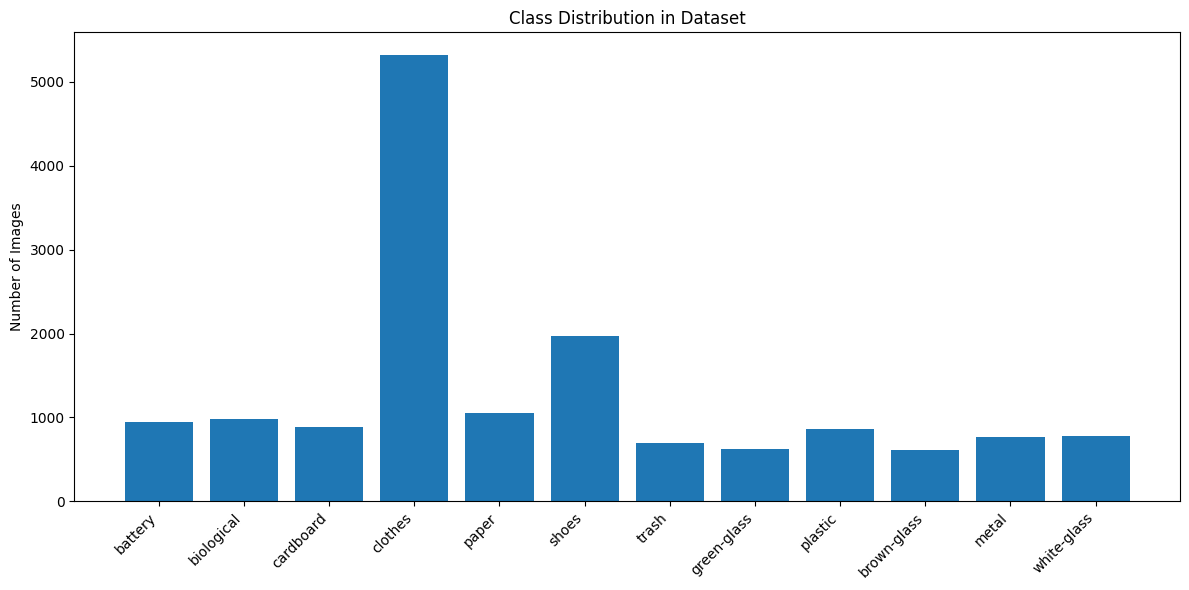

Most common class has 5325 images
Least common class has 607 images
Imbalance ratio: 8.77:1


In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45, ha='right')
plt.title('Class Distribution in Dataset')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

# Calculate imbalance ratios
max_count = max(class_counts.values())
min_count = min(class_counts.values())
print(f"Most common class has {max_count} images")
print(f"Least common class has {min_count} images")
print(f"Imbalance ratio: {max_count/min_count:.2f}:1")

In [ ]:
base_dir = '/content/data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [ ]:
os.makedirs(base_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [ ]:
class_names = []
for item in os.listdir(dataset_path):
    if os.path.isdir(os.path.join(dataset_path, item)):
        class_names.append(item)

print("Class names found:", class_names)

Class names found: ['battery', 'biological', 'cardboard', 'clothes', 'paper', 'shoes', 'trash', 'green-glass', 'plastic', 'brown-glass', 'metal', 'white-glass']


In [ ]:
for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

In [ ]:
for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    images = os.listdir(class_path)

    # Split images into train and test
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

    # Copy images to train directory
    for img in train_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(train_dir, class_name, img)
        shutil.copyfile(src, dst)

    # Copy images to test directory
    for img in test_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(test_dir, class_name, img)
        shutil.copyfile(src, dst)

    print(f"Class {class_name}: {len(train_images)} training images, {len(test_images)} test images")

Class battery: 756 training images, 189 test images
Class biological: 788 training images, 197 test images
Class cardboard: 712 training images, 179 test images
Class clothes: 4260 training images, 1065 test images
Class paper: 840 training images, 210 test images
Class shoes: 1581 training images, 396 test images
Class trash: 557 training images, 140 test images
Class green-glass: 503 training images, 126 test images
Class plastic: 692 training images, 173 test images
Class brown-glass: 485 training images, 122 test images
Class metal: 615 training images, 154 test images
Class white-glass: 620 training images, 155 test images


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest',
    validation_split=0.2
)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 9930 images belonging to 12 classes.
Found 2479 images belonging to 12 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3106 images belonging to 12 classes.


In [ ]:
class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)
print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", validation_generator.samples)
print("Number of test samples:", test_generator.samples)

Class names: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Number of training samples: 9930
Number of validation samples: 2479
Number of test samples: 3106


In [ ]:
class_weights = {}
for i, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    num_images = len(os.listdir(class_path))
    # Inverse frequency weighting
    class_weights[i] = train_generator.samples / (len(class_names) * num_images)

print("Class weights:")
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {class_weights[i]:.2f}")

Class weights:
battery: 1.09
biological: 1.05
brown-glass: 1.71
cardboard: 1.16
clothes: 0.19
green-glass: 1.65
metal: 1.35
paper: 0.99
plastic: 1.20
shoes: 0.52
trash: 1.49
white-glass: 1.33


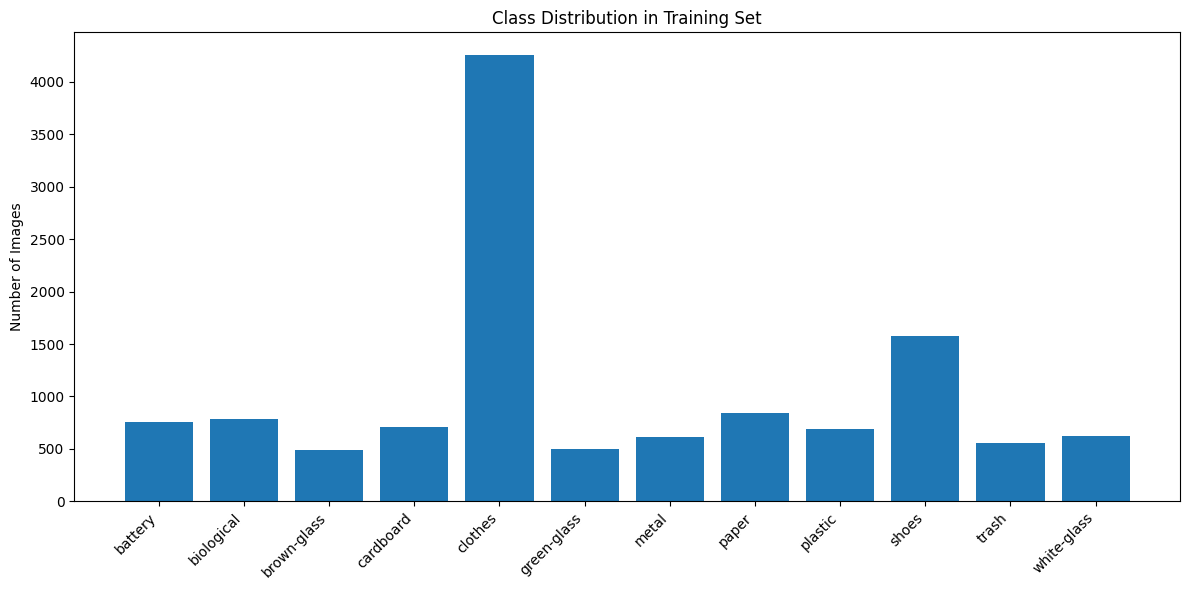

In [ ]:
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    class_counts[class_name] = len(os.listdir(class_path))

plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45, ha='right')
plt.title('Class Distribution in Training Set')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

In [ ]:
def create_simple_model(num_classes):
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg'
    )

    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
model = create_simple_model(len(class_names))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 12)             │        15,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,064,943 (15.51 MB)

 Trainable params: 15,372 (60.05 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
print("Let's examine a batch of data from the generator...")

# Get one batch from the generator
for images, labels in train_generator:
    break

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Labels sample: {labels[0]}")
print(f"Image pixel range: {np.min(images)} to {np.max(images)}")

Let's examine a batch of data from the generator...
Images shape: (32, 224, 224, 3)
Labels shape: (32, 12)
Labels sample: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Image pixel range: 0.0 to 1.0


New Architecture

In [ ]:
simple_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = simple_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = simple_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 9930 images belonging to 12 classes.
Found 2479 images belonging to 12 classes.


In [ ]:
def create_better_model(num_classes):
    # Use ResNet50 which is often more stable than EfficientNet
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg'
    )

    # Freeze the base model
    base_model.trainable = False

    # Create a simple model on top
    model = models.Sequential([
        base_model,
        layers.Dropout(0.5),  # More dropout for regularization
        layers.Dense(256, activation='relu'),  # Add an intermediate layer
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
model = create_better_model(len(class_names))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,115,340 (91.99 MB)

 Trainable params: 527,628 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    ]
)

Epoch 1/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 63s 159ms/step - accuracy: 0.0972 - loss: 2.9891 - val_accuracy: 0.1134 - val_loss: 2.4168
Epoch 2/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 35s 114ms/step - accuracy: 0.1033 - loss: 2.5740 - val_accuracy: 0.1138 - val_loss: 2.4095
Epoch 3/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step - accuracy: 0.1176 - loss: 2.4736 - val_accuracy: 0.2469 - val_loss: 2.3719
Epoch 4/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - accuracy: 0.1400 - loss: 2.4015 - val_accuracy: 0.1940 - val_loss: 2.3626
Epoch 5/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - accuracy: 0.1397 - loss: 2.4075 - val_accuracy: 0.1807 - val_loss: 2.3566
Epoch 6/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - accuracy: 0.1450 - loss: 2.3486 - val_accuracy: 0.2154 - val_loss: 2.3298
Epoch 7/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - accuracy: 0.1553 - loss: 2.3284 - val_accuracy: 0.1997 - val_loss: 2.3045
Epoch 8/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step - accuracy: 0.1638 - loss: 2

Trying new architecture

In [ ]:
SMALL_SIZE = (128, 128)

small_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

small_train_generator = small_datagen.flow_from_directory(
    train_dir,
    target_size=SMALL_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

Found 9930 images belonging to 12 classes.


In [ ]:
small_val_generator = small_datagen.flow_from_directory(
    train_dir,
    target_size=SMALL_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 2479 images belonging to 12 classes.


In [ ]:
def create_simple_cnn(num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [ ]:
simple_model = create_simple_cnn(len(class_names))
simple_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

simple_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,188 (12.61 MB)

 Trainable params: 3,306,188 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
simple_history = simple_model.fit(
    small_train_generator,
    epochs=15,
    validation_data=small_val_generator,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    ]
)

Epoch 1/15
311/311 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.8251 - loss: 0.4999 - val_accuracy: 0.6954 - val_loss: 1.1304
Epoch 2/15
311/311 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.8412 - loss: 0.4485 - val_accuracy: 0.7019 - val_loss: 1.1264
Epoch 3/15
311/311 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step - accuracy: 0.8611 - loss: 0.3862 - val_accuracy: 0.6507 - val_loss: 1.2784
Epoch 4/15
311/311 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.8609 - loss: 0.3568 - val_accuracy: 0.6846 - val_loss: 1.2973
Epoch 5/15
311/311 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.8787 - loss: 0.3495 - val_accuracy: 0.7055 - val_loss: 1.1981
Epoch 6/15
311/311 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.8928 - loss: 0.2803 - val_accuracy: 0.6837 - val_loss: 1.4365
Epoch 7/15
311/311 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.8983 - loss: 0.2729 - val_accuracy: 0.7003 - val_loss: 1.2677


Improvement

In [40]:
def create_regularized_cnn(num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [41]:
regularized_model = create_regularized_cnn(len(class_names))
regularized_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

regularized_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,117,644 (19.52 MB)

 Trainable params: 5,115,660 (19.51 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [42]:
regularized_history = regularized_model.fit(
    small_train_generator,
    epochs=20,
    validation_data=small_val_generator,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ]
)

Epoch 1/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.2930 - loss: 2.6394 - val_accuracy: 0.0573 - val_loss: 6.4938 - learning_rate: 1.0000e-04
Epoch 2/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.4867 - loss: 1.7679 - val_accuracy: 0.3526 - val_loss: 2.7982 - learning_rate: 1.0000e-04
Epoch 3/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.5591 - loss: 1.4893 - val_accuracy: 0.4526 - val_loss: 2.2075 - learning_rate: 1.0000e-04
Epoch 4/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.5937 - loss: 1.3523 - val_accuracy: 0.4002 - val_loss: 2.6237 - learning_rate: 1.0000e-04
Epoch 5/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/step - accuracy: 0.6140 - loss: 1.2640 - val_accuracy: 0.4905 - val_loss: 2.2370 - learning_rate: 1.0000e-04
Epoch 6/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.6437 - loss: 1.1287 - val_accuracy: 0.5361 - val_loss: 1.8404 - learning_rate: 1.0000e-04
Epoch 7/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 17s 56ms/ste

In [43]:
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    validation_split=0.2
)

augmented_train_generator = augmented_datagen.flow_from_directory(
    train_dir,
    target_size=SMALL_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

augmented_val_generator = augmented_datagen.flow_from_directory(
    train_dir,
    target_size=SMALL_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 9930 images belonging to 12 classes.
Found 2479 images belonging to 12 classes.


In [44]:
augmented_history = regularized_model.fit(
    augmented_train_generator,
    epochs=20,
    validation_data=augmented_val_generator,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3),
    ]
)

Epoch 1/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 64s 204ms/step - accuracy: 0.6909 - loss: 1.0335 - val_accuracy: 0.6067 - val_loss: 1.5946 - learning_rate: 1.0000e-04
Epoch 2/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 62s 198ms/step - accuracy: 0.7082 - loss: 0.9421 - val_accuracy: 0.6321 - val_loss: 1.3827 - learning_rate: 1.0000e-04
Epoch 3/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 83s 200ms/step - accuracy: 0.7230 - loss: 0.8718 - val_accuracy: 0.6176 - val_loss: 1.5517 - learning_rate: 1.0000e-04
Epoch 4/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 62s 200ms/step - accuracy: 0.7132 - loss: 0.8511 - val_accuracy: 0.6398 - val_loss: 1.3469 - learning_rate: 1.0000e-04
Epoch 5/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 62s 199ms/step - accuracy: 0.7345 - loss: 0.8201 - val_accuracy: 0.6579 - val_loss: 1.2577 - learning_rate: 1.0000e-04
Epoch 6/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 63s 202ms/step - accuracy: 0.7439 - loss: 0.8169 - val_accuracy: 0.6341 - val_loss: 1.4092 - learning_rate: 1.0000e-04
Epoch 7/20
311/311 ━━━━━━━━━━━━━━━━━━━━ 62s 19

Found 3106 images belonging to 12 classes.
98/98 ━━━━━━━━━━━━━━━━━━━━ 9s 94ms/step - accuracy: 0.7646 - loss: 0.8357
Test accuracy: 79.04%
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step


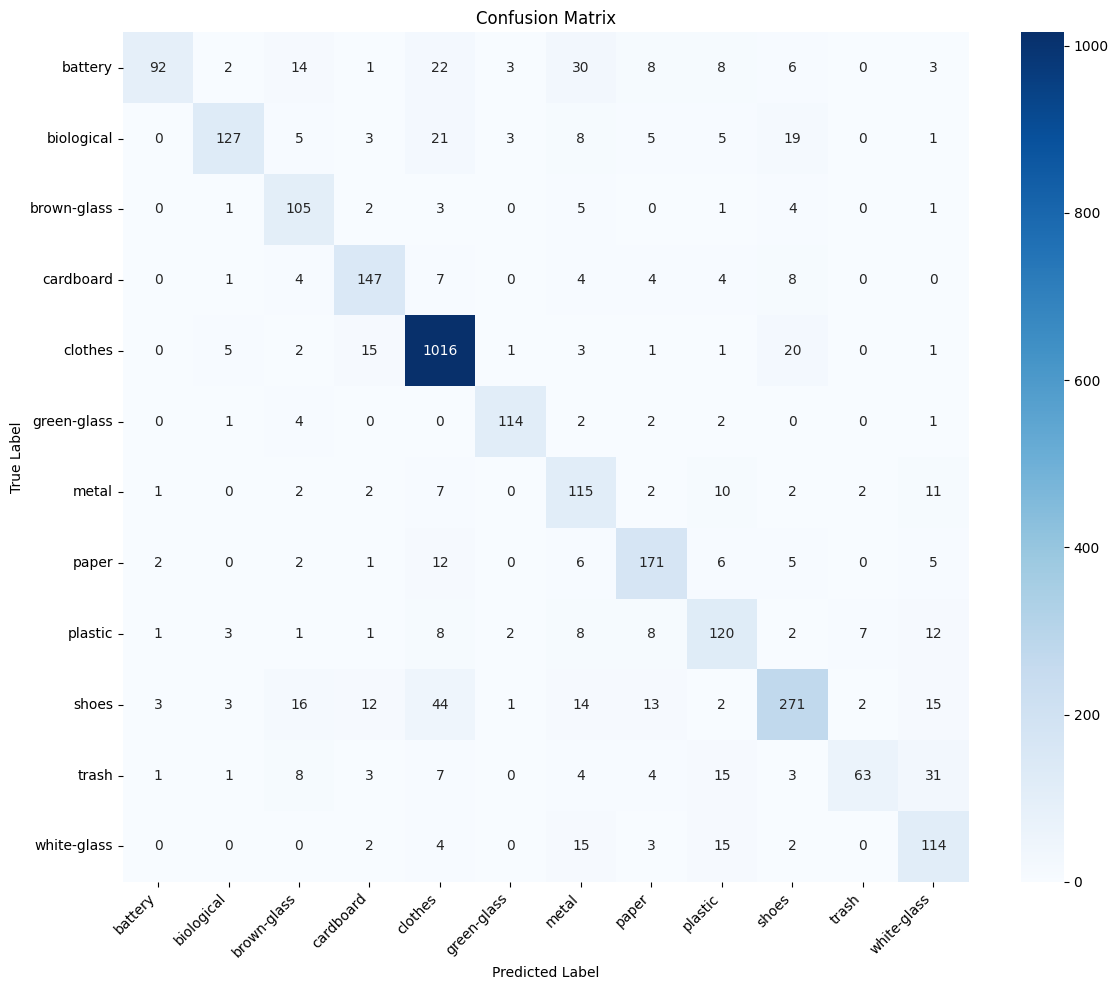

Classification Report:
              precision    recall  f1-score   support

     battery       0.92      0.49      0.64       189
  biological       0.88      0.64      0.74       197
 brown-glass       0.64      0.86      0.74       122
   cardboard       0.78      0.82      0.80       179
     clothes       0.88      0.95      0.92      1065
 green-glass       0.92      0.90      0.91       126
       metal       0.54      0.75      0.62       154
       paper       0.77      0.81      0.79       210
     plastic       0.63      0.69      0.66       173
       shoes       0.79      0.68      0.73       396
       trash       0.85      0.45      0.59       140
 white-glass       0.58      0.74      0.65       155

    accuracy                           0.79      3106
   macro avg       0.77      0.73      0.73      3106
weighted avg       0.80      0.79      0.79      3106



In [45]:
test_generator = small_datagen.flow_from_directory(
    test_dir,
    target_size=SMALL_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_accuracy = regularized_model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

predictions = regularized_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [46]:
# Save the best model
regularized_model.save('garbage_classifier_final.h5')

# Copy to Google Drive
drive_path = '/content/drive/MyDrive/garbage_classifier_final.h5'
shutil.copy('garbage_classifier_final.h5', drive_path)
print(f"Model saved to {drive_path}")

# Also save the class labels for later use
import json
with open('class_labels.json', 'w') as f:
    json.dump(class_labels, f)

shutil.copy('class_labels.json', '/content/drive/MyDrive/class_labels.json')
print("Class labels saved")

Model saved to /content/drive/MyDrive/garbage_classifier_final.h5
Class labels saved
